In [600]:
%run DL_func.ipynb

In [601]:
from sklearn.metrics import r2_score

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn.

In [602]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [603]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Z3,Y,Env_mean,Env,c
0,-0.92,-0.86,-3.12,-2.72,0.2,0,red
1,4.52,6.58,7.91,9.99,5.0,3,yellow
2,0.26,1.71,2.43,2.70,0.2,0,red
3,-0.53,3.20,4.87,4.31,0.2,0,red
4,6.09,7.57,13.40,14.52,5.0,3,yellow
...,...,...,...,...,...,...,...
3995,-0.70,-1.20,-2.23,-1.84,0.2,0,red
3996,5.70,10.22,15.19,16.59,5.0,3,yellow
3997,2.45,5.97,6.84,7.91,3.0,2,green
3998,-0.09,3.52,4.60,4.58,0.2,0,red


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

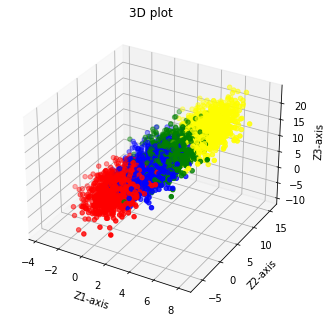

In [604]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [605]:
net=Net(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [606]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [607]:
z_dim = 3
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1

net=UglyiVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, 3, beta=1)

In [608]:
x,y,e = next(iter(train_loader))
elbo = net.elbo(x.float(),y.float(),e.float())

In [609]:
elbo

tensor(-269.7441, grad_fn=<MeanBackward0>)

In [610]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 100
Train loss: tensor(3.8166)
Epoch 40 of 100
Train loss: tensor(-1.8504)
Epoch 60 of 100
Train loss: tensor(-4.7392)
Epoch 80 of 100
Train loss: tensor(-6.3723)
Epoch 100 of 100
Train loss: tensor(-7.1698)


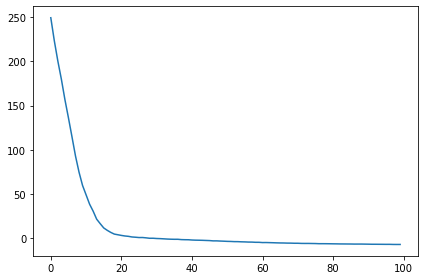

In [611]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [612]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [613]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [614]:
#%matplotlib qt
#plot_latent_3d(df, m)

In [615]:
pdf=df[['Z1', 'Z2', 'Z3']]
pdf.columns = ['pZ1', 'pZ2', 'pZ3']
cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values
cdf['pZ3']=pdf['pZ3'].values

corrs=cdf.corr().iloc[:3,3:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs).max().mean()
mcc, mcc_abs

(-0.6627652123020492, 0.8517039294244028)

In [616]:
def MCC(true_z, predicted_z):
    """Caluclates the Correlation Coefficient between all pairs of true 
    and recovered latent variables for one environment 

    Uses Pearsons Corr Coef

    from paper: 
    We also compute the mean correlation coefficient (MCC) used in Khemakhem et al. (2020a), which
    can be obtained by calculating the correlation coefficient between all pairs of true and recovered
    latent factors and then solving a linear sum assignment problem by assigning each recovered latent
    factor to the true latent factor with which it best correlates

    Args:
        true_z (numpy array): 2D dimensional numpy array, where columns represent variables
        predicted_z (numpy array): _description_
    """
    num_true = len(true_z[0])
    num_predicted = len(predicted_z[0])
    corr_matrix = np.abs(np.corrcoef(true_z, predicted_z, rowvar=False))
    reduced_matrix = corr_matrix[
        0:num_true, num_true : len(corr_matrix[0]) + 1
    ]  # where rows are true and columns are predicted
    row_ind, col_ind = linear_sum_assignment(reduced_matrix, maximize=True)

    mcc = [reduced_matrix[row_ind[i], col_ind[i]] for i in range(len(row_ind))]
    print(mcc)
    mcc = np.sum(mcc) / (num_predicted)
    return mcc

In [617]:
MCC(cdf.iloc[:,:3].values, pdf.values)

[0.7947755428947788, 0.946588256970429, 0.7819469015897946]


0.8411035671516675

In [618]:
corrs

,pZ1,pZ2,pZ3
Z1,-0.712697,-0.725865,-0.794776
Z2,-0.669940,-0.946588,-0.592490
Z3,-0.781947,-0.969389,-0.803776


In [619]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
df['Y']=Y[2000:3920]

dfc=pd.concat([df,pd.get_dummies(df['Env'],drop_first=True)],axis=1)
dfc['Z1x_1']=dfc['Z1']*dfc[1]
dfc['Z1x_2']=dfc['Z1']*dfc[2]
dfc['Z1x_3']=dfc['Z1']*dfc[3]
dfc['Z2x_1']=dfc['Z2']*dfc[1]
dfc['Z2x_2']=dfc['Z2']*dfc[2]
dfc['Z2x_3']=dfc['Z2']*dfc[3]
dfc['Z3x_1']=dfc['Z3']*dfc[1]
dfc['Z3x_2']=dfc['Z3']*dfc[2]
dfc['Z3x_3']=dfc['Z3']*dfc[3]
train=dfc.iloc[:1600,:]
test=dfc.iloc[:1600,:]

In [620]:
def predict_y(df, x_train, y_train, x_test, y_test, linear=True):
    if linear:
        lm = pg.linear_regression(x_train,y_train)
        print(lm)
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        print(r2_score(y_pred, y_test))
        
        return y_pred
    
    

In [621]:
train=df.iloc[:1600,:]
test=df.iloc[:1600,:]

In [622]:
y_pred=predict_y(dfc, train[['Z1', 'Z2', 'Z3']], train['Y'], test[['Z1', 'Z2', 'Z3']], test['Y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['Y'], test[['Z1', 'Z2']], test['Y'])
y_pred=predict_y(dfc, train[['Z3']], train['Y'], test[['Z3']], test['Y'])

       names      coef        se          T          pval        r2   adj_r2  \
0  Intercept  2.991490  0.160483  18.640489  2.561305e-70  0.914601  0.91444   
1         Z1 -0.694411  0.128589  -5.400227  7.660002e-08  0.914601  0.91444   
2         Z2 -3.054210  0.043154 -70.774337  0.000000e+00  0.914601  0.91444   
3         Z3 -0.728969  0.090167  -8.084671  1.219831e-15  0.914601  0.91444   

   CI[2.5%]  CI[97.5%]  
0  2.676709   3.306270  
1 -0.946633  -0.442190  
2 -3.138855  -2.969565  
3 -0.905827  -0.552111  
0.9066266680152539
       names      coef        se          T           pval        r2  \
0  Intercept  1.805630  0.066414  27.187614  4.347457e-134  0.911103   
1         Z1 -1.194924  0.114954 -10.394792   1.555560e-24  0.911103   
2         Z2 -3.186074  0.040750 -78.185291   0.000000e+00  0.911103   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.910992  1.675363   1.935897  
1  0.910992 -1.420400  -0.969447  
2  0.910992 -3.266004  -3.106145  
0.9024295263725084
       

## Case with just 2 latent variables ##

In [623]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [624]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Y,Env_mean,Env,c
0,-0.71,3.71,1.31,0.2,0,red
1,4.51,9.55,12.99,5.0,3,yellow
2,3.99,1.19,6.09,2.0,1,blue
3,3.68,8.80,11.38,3.0,2,green
4,3.68,13.17,17.00,5.0,3,yellow
...,...,...,...,...,...,...
3995,1.16,5.93,6.33,3.0,2,green
3996,5.05,5.49,9.91,5.0,3,yellow
3997,3.39,10.67,14.88,5.0,3,yellow
3998,2.33,5.66,8.93,3.0,2,green


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

In [625]:
# for creating a responsive plot
#%matplotlib qt

#plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [626]:
net=Net1(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [627]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [628]:
net=UglyiVAE(x.float(), y.float(), e.float(), 15, 2, 2, 10, 5, 2, beta=1)

In [629]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(18.1402)
Epoch 40 of 200
Train loss: tensor(4.1158)
Epoch 60 of 200
Train loss: tensor(0.8008)
Epoch 80 of 200
Train loss: tensor(-0.1428)
Epoch 100 of 200
Train loss: tensor(-0.5999)
Epoch 120 of 200
Train loss: tensor(-1.0739)
Epoch 140 of 200
Train loss: tensor(-1.3175)
Epoch 160 of 200
Train loss: tensor(-1.7824)
Epoch 180 of 200
Train loss: tensor(-4.0342)
Epoch 200 of 200
Train loss: tensor(-5.3215)


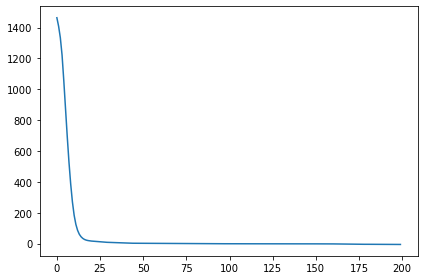

In [630]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [631]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [632]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

<Figure size 1440x864 with 0 Axes>

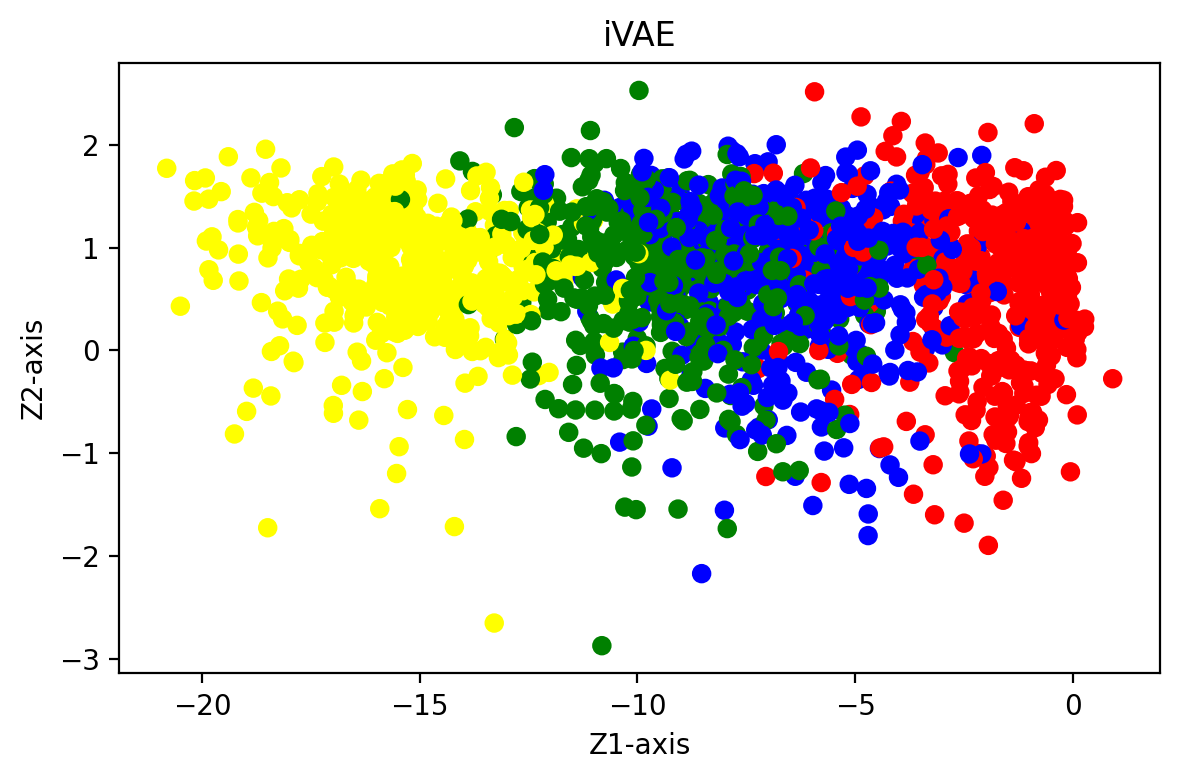

In [648]:
#%matplotlib qt
#plot_latent_3d(df, m)
fig = plt.figure()


# creating the plot
plt.figure(figsize=(6,4), dpi=200)
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("iVAE")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')
plt.savefig('iVAE_2d.jpg')

In [634]:
pdf=df[['Z1', 'Z2']]
pdf.columns = ['pZ1', 'pZ2']
cdf=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values

corrs=cdf.corr().iloc[:2,2:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs).max().mean()
mcc, mcc_abs

(-0.26514171029720757, 0.6624336174939535)

In [635]:
MCC(cdf.iloc[:,:2].values, pdf.values)

[0.9277160194475271, 0.3971512155403792]


0.6624336174939531

In [636]:
np.abs(corrs)
corrs
cdf.corr()

,Z1,Z2,pZ1,pZ2
Z1,1.000000,0.748368,-0.927716,-0.112629
Z2,0.748368,1.000000,-0.927435,0.397151
pZ1,-0.927716,-0.927435,1.000000,-0.138837
pZ2,-0.112629,0.397151,-0.138837,1.000000


In [637]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
df['y']=Y[2000:3920]

dfc=pd.concat([df,pd.get_dummies(df['Env'],drop_first=True)],axis=1)
dfc['Z1x_1']=dfc['Z1']*dfc[1]
dfc['Z1x_2']=dfc['Z1']*dfc[2]
dfc['Z1x_3']=dfc['Z1']*dfc[3]
dfc['Z2x_1']=dfc['Z2']*dfc[1]
dfc['Z2x_2']=dfc['Z2']*dfc[2]
dfc['Z2x_3']=dfc['Z2']*dfc[3]
train=dfc.iloc[:1600,:]
test=dfc.iloc[:1600,:]

In [638]:
def predict_y(df, x_train, y_train, x_test, y_test, linear=True):
    if linear:
        lm = pg.linear_regression(x_train,y_train)
        print(lm)
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        print(r2_score(y_pred, y_test))
        
        return y_pred
    
    

In [639]:
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['y'], test[['Z1', 'Z2']], test['y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])

       names      coef        se           T  pval        r2   adj_r2  \
0  Intercept -2.087386  0.034317  -60.827220   0.0  0.986477  0.98646   
1         Z1 -1.050712  0.003251 -323.151641   0.0  0.986477  0.98646   
2         Z2  1.547616  0.023741   65.186519   0.0  0.986477  0.98646   

   CI[2.5%]  CI[97.5%]  
0 -2.154696  -2.020075  
1 -1.057089  -1.044334  
2  1.501048   1.594183  
0.9862914669908331


In [640]:
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['y'], test[['Z1', 'Z2']], test['y'])

       names      coef        se           T  pval        r2   adj_r2  \
0  Intercept -2.087386  0.034317  -60.827220   0.0  0.986477  0.98646   
1         Z1 -1.050712  0.003251 -323.151641   0.0  0.986477  0.98646   
2         Z2  1.547616  0.023741   65.186519   0.0  0.986477  0.98646   

   CI[2.5%]  CI[97.5%]  
0 -2.154696  -2.020075  
1 -1.057089  -1.044334  
2  1.501048   1.594183  
0.9862914669908331


In [641]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
MSE(y_pred, test['y'])
r2_score(y_pred, test['y'])

0.9862914669908331

In [642]:
graphdf=df[['Z1', 'Z2', 'y']]

In [643]:
graphdf.values

array([[ -8.4791069 ,  -0.10255274,   6.8495146 ],
       [ -9.30405807,   0.59957755,   7.75931074],
       [ -7.91871166,   1.9845202 ,  10.05843133],
       ...,
       [-14.23779488,   1.26170278,  15.33468572],
       [ -8.1871357 ,   0.74045998,   7.29712806],
       [-14.03482628,   0.64404786,  13.67258824]])

In [644]:
from causallearn.utils.cit import CIT
kci_obj = CIT(graphdf.values, "kci") 
kci_obj(0,1, {2})
#pE = kci_obj(0, 1, {3})
#pYE = kci_obj(0, 1, {2, 3})

0.0

In [645]:
from causallearn.search.ConstraintBased.PC import pc   
cg = pc(graphdf.values, 0.25)

  0%|          | 0/3 [00:00<?, ?it/s]

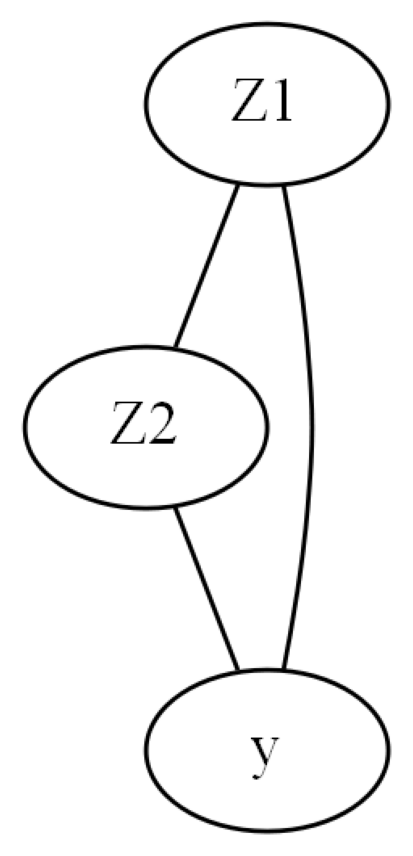

In [646]:
# visualization using pydot
cg.draw_pydot_graph(labels = graphdf.columns)

In [647]:
# Get skeleton graph
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()
# apply graph lasso to data
skeleton = glasso.predict(dfc)
# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

NameError: name 'cdt' is not defined

In [ ]:
# Use causal discovery to get causal models
# PC algorithm
model_pc = cdt.causality.graph.PC()
graph_pc = model_pc.predict(dfc, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r')